In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-xkvh0e8o
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-xkvh0e8o
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=5038c81e80c3b406cf631d8e06cd35ffa7af275d7bc813066c3e68b02ef351ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-aoqx57n1/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


# Wersja CPU
_____

- Sekcja 1: Deklaracja i definicja struktury **cuComplex**, która składa się z dwóch zmiennych typu *float*: r i i. Struktura ta zawiera również trzy metody: **magnitude2, operator *,** a także **operator +**, które odpowiednio zwracają kwadrat magnitudy liczby zespolonej, mnożą dwie liczby zespolone i dodają dwie liczby zespolone.

- Sekcja 2: Definicja funkcji **mandelbrot**, która przyjmuje dwa argumenty: x i y. Funkcja ta oblicza wartość fraktala Mandelbrota dla danego punktu (x, y) na podstawie liczby zespolonej p i liczby zespolonej a. Jeśli wartość kwadratu magnitudy liczby a przekracza 1000, funkcja zwraca 0, w przeciwnym razie zwraca 1.

- Sekcja 3: Definicja funkcji **kernel**, która przyjmuje jeden argument: wskaźnik typu *unsigned char*. Funkcja ta iteruje przez wszystkie punkty w obrazie o rozmiarze DIM x DIM i dla każdego punktu wywołuje funkcję *mandelbrot*, aby uzyskać wartość fraktala. Następnie ustawia kanały R, G i B dla tego punktu na podstawie wartości fraktala.

- Sekcja 4: Struktura **DataBlock** składa się tylko z jednego pola, którym jest wskaźnik **dev_bitmap** typu *unsigned char*. Ten wskaźnik wskazuje na pamięć wykorzystywaną przez obraz fraktala, który jest generowany przez kernel. Jest to wskaźnik na pamięć na urządzeniu, który jest przydatny przy obliczeniach na urządzeniach zewnętrznych (GPU).

- Sekcja 5: Definicja funkcji **wypisz_RGB_fraktal**, która przyjmuje jeden argument: wskaźnik typu *unsigned char*. Funkcja ta iteruje przez wszystkie punkty w obrazie i dla każdego punktu wypisuje wartości kanałów R, G i B.

- Sekcja 6: Definicja funkcji **save_to_file**, która przyjmuje jeden argument: wskaźnik typu *unsigned char*. Funkcja ta otwiera plik o nazwie "Fraktal_CPU.txt" w trybie zapisu i zapisuje rozmiar obrazu oraz wartości kanałów R, G i B dla każdego punktu w obrazie.

- Sekcja 7: Kod główny programu, w którym tworzone są zmienne **start** i **stop**, które służą do pomiaru czasu generowania obrazu. Następnie alokuje się pamięć dla bitmapy i wywołuje funkcję **kernel**, która generuje obraz fraktala. Po zakończeniu generowania obrazu, rejestrowany jest czas końcowy i obliczany jest czas trwania generowania obrazu. Następnie zwalnia się zaalokowaną pamięć i zapisuje obraz do pliku.

In [ ]:
%%cu
#include <stdio.h>
#define DIM 6000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a,float b):r(a),i(b){}
    float magnitude2(void){ return r*r+i*i;}
    cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}
};

int mandelbrot(int x, int y){
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2-x) / (DIM/2);
    float jy = scale * (float)(DIM/2-y) / (DIM/2);
    cuComplex p(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
        a = a * a + p;
        if (a.magnitude2()>1000) 
        return 0;
    }
    return 1;
}

void kernel(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;
            int mandelValue = mandelbrot(x,y);
            ptr[offset*4+0] = 0;
            ptr[offset*4+1] = 255 * mandelValue;
            ptr[offset*4+2] = 155 * mandelValue;
        }
    }
}

//Zapis fraktala
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;

            printf("%d,%d,%d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
}

void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.txt","w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset=x+y*DIM;
            fprintf(fp, "%d,%d,%d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
    fclose(fp);
}

int main(void){
cudaEvent_t start, stop;
cudaEventCreate(&start);
cudaEventCreate(&stop);
cudaEventRecord( start, 0 );

    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);

//stop pomiaru czasu i obliczenie jego trwania
cudaEventRecord(stop,0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime,start,stop);
printf("Time to generate: %3.1f ms\n",elapsedTime);
//wyczyszczenie pamieci
cudaEventDestroy(start);
cudaEventDestroy(stop);

    save_to_file(bitmap);
}

Time to generate: 43511.7 ms



# Wersja GPU
_____

1. Sekcja `#include <stdio.h>` i `#define DIM 1000` - W tym fragmencie kodu jest zaimportowany plik nagłówkowy **stdio.h**, który zawiera funkcje do wejścia/wyjścia danych, oraz zdefiniowana stała **DIM**, która będzie używana do określenia rozmiaru obrazu generowanego fraktala.

1. Sekcja `struct cuComplex` - W tej sekcji zdefiniowano strukturę **cuComplex**, która składa się z dwóch zmiennych typu float: r i i. Struktura ta posiada również trzy metody: **konstruktor cuComplex, magnitude2 i operator overloads** dla mnożenia i dodawania. Konstruktor ustawia wartości r i i na podane parametry a i b, metoda magnitude2 zwraca kwadrat magnitudy liczby zespolonej, a operatory overloads pozwalają na mnożenie i dodawanie dwóch liczb zespolonych.

1. Sekcja `device int mandelbrot(int x, int y)` - W tej sekcji zdefiniowano funkcję mandelbrot, która jest wykonywana na GPU. Funkcja ta przyjmuje dwa parametry: x i y, które reprezentują współrzędne punktu na ekranie. Funkcja ta zwraca 1 lub 0 w zależności od tego, czy punkt znajduje się wewnątrz czy na zewnątrz fraktala Mandelbrota.

1. Sekcja ` global void kernel( unsigned char *ptr )` - W tej sekcji zdefiniowano **kernel**, czyli funkcję, która jest wykonywana na GPU. Kernel przyjmuje jeden parametr - wskaźnik na tablicę typu *unsigned char*. Funkcja ta odwzorowuje indeks bloku na współrzędne piksela na ekranie, a następnie wywołuje funkcję **mandelbrot** dla danego punktu i zapisuje wynik w tablicy ptr.

1. Sekcja `struct DataBlock` - W tej sekcji zdefiniowano strukturę DataBlock, która składa się z jednego pola - wskaźnika na tablicę dev_bitmap typu unsigned char.

1. Sekcja `void wypisz_RGB_fraktal(unsigned char *ptr)` - W tej sekcji zdefiniowano funkcję wypisz_RGB_fraktal, która przyjmuje jeden parametr - wskaźnik na tablicę ptr typu *unsigned char*. Funkcja ta wypisuje na ekranie wartości RGB dla każdego punktu fraktala.

1. Sekcja `void save_to_file(unsigned char *ptr)` - W tej sekcji zdefiniowano funkcję save_to_file, która przyjmuje jeden parametr - wskaźnik na tablicę **ptr** typu *unsigned char*. Funkcja ta zapisuje wartości RGB dla każdego punktu fraktala do pliku tekstowego o nazwie "Fraktal_GPU.txt".

1. Sekcja `int main(void)` - W tej sekcji znajduje się główna funkcja programu, która jest wykonywana na CPU. Funkcja ta inicjuje pomiar czasu, alokuje pamięć na GPU dla tablicy **dev_bitmap**, wywołuje kernel na GPU, kopiuje wynik z GPU do pamięci CPU, kończy pomiar czasu i wypisuje czas trwania obliczeń oraz zapisuje fraktal do pliku.

In [ ]:
%%cu
#include <stdio.h>
#define DIM 6000

struct cuComplex{
    float r;
    float i;
    
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i;}
    __device__ cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    __device__ cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}
};
__device__ int mandelbrot(int x, int y) {
    const float scale = 1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex p(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
        a = a * a + p;
        if (a.magnitude2()>1000) 
        return 0;
    }
    return 1;
}

__global__ void kernel( unsigned char *ptr ) {
  // Odwzorowanie z blockldx na współrzędne piksela
  int x = blockIdx.x;
  int y = blockIdx.y;
  int offset = x + y * gridDim.x;
  // Obliczenie wartości dla tego punktu
  int mandelValue = mandelbrot ( x, y );
  ptr[offset*4 + 0] = 255 * mandelValue;
  ptr[offset*4 + 1] = 0;
  ptr[offset*4 +2] = 255 * mandelValue;
}

//Zapis fraktala
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;

            printf("%d, %d, %d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
}

void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.txt","w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset=x+y*DIM;
            fprintf(fp, "%d, %d, %d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
    fclose(fp);
}

int main(void){
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  cudaEventRecord( start, 0 );


  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
  int image_size = DIM*DIM*4;
  unsigned char *dev_bitmap;
  cudaMalloc((void**)&dev_bitmap, image_size);
  data.dev_bitmap=dev_bitmap;
  dim3 grid(DIM,DIM);
  kernel<<<grid,1>>>(dev_bitmap);
  cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);

  //stop pomiaru czasu i obliczenie jego trwania
  cudaEventRecord(stop,0);
  cudaEventSynchronize(stop);
  float elapsedTime;
  cudaEventElapsedTime(&elapsedTime,start,stop);
  printf("Time to generate: %3.1f ms\n",elapsedTime);
  //wyczyszczenie pamieci
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  cudaFree(dev_bitmap);
  save_to_file (bitmap);
}

Time to generate: 389.5 ms



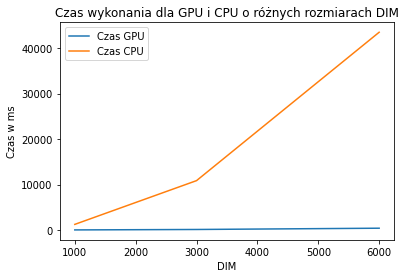

In [ ]:
import matplotlib.pyplot as plt

dim_size = [1000, 3000, 6000]
gpu_time = [12.6, 108.6, 389.5]
cpu_time = [1231.4, 10858.5, 43511.7]

plt.plot(dim_size, gpu_time, label='Czas GPU')
plt.plot(dim_size, cpu_time, label='Czas CPU')
plt.xlabel('DIM')
plt.ylabel('Czas w ms')
plt.legend()
plt.title('Czas wykonania dla GPU i CPU o różnych rozmiarach DIM')
plt.show()


In [ ]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

contents = Path('Fraktal_GPU.txt').read_text()

h, w, *pixels = re.findall(r'[0-9]+', contents)

na = np.array(pixels, dtype=np.uint8).reshape((int(h),int(w),3))

Image.fromarray(na).save("wynik_GPU.png")

/content/wynik_GPU.png

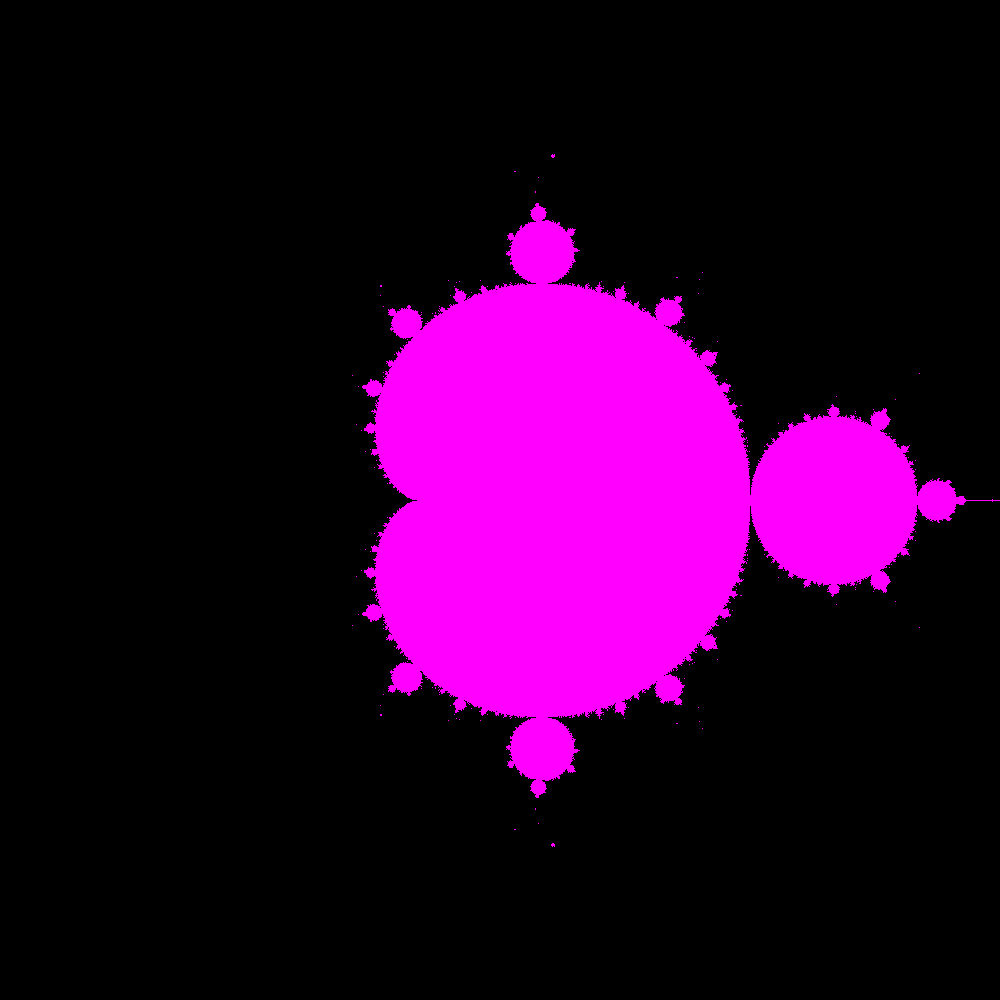